# Predicting the Sale Price of Bulldozers using Machine Learning 

In this note , We're going to predict the sale price of Bulldozers which is a classical problem of Machine Learning on kaggle

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.



In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [5]:
# Import trainning and validation sets
df = pd.read_csv("data/TrainAndValid.csv",low_memory = False)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

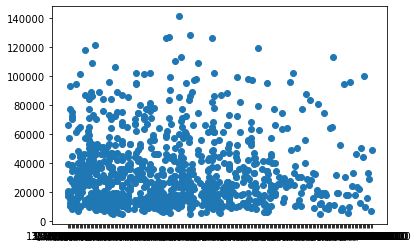

In [9]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

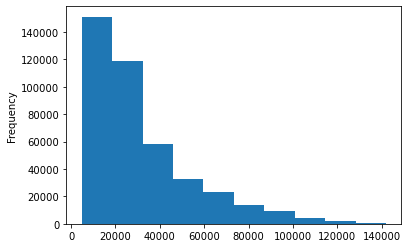

In [12]:
df.SalePrice.plot.hist();

## Data Cleaning
### Parsing dates 

When we work with time series data, we want to enrich the time & date component as much as possible

In [14]:
# Import data again with parse dates 

df = pd.read_csv("data/TrainAndValid.csv",low_memory = False,parse_dates = ["saledate"])

In [15]:
df.saledate.dtype

dtype('<M8[ns]')

In [16]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

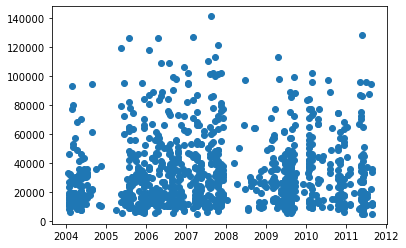

In [19]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

In [20]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by date

When working with time series data, it's good to sort it by date

In [24]:
# Sort DataFrame in date order 
df.sort_values(by = ["saledate"], inplace = True, ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [25]:
# Make a copy of DataFrame
df_tmp = df.copy()

In [26]:
df_tmp.head().T


,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

In [27]:
df_tmp.saledate[:1].dt.year

205615    1989
Name: saledate, dtype: int64

In [28]:
df_tmp.saledate[:1].dt.day

205615    17
Name: saledate, dtype: int64

In [29]:
df_tmp.saledate[:1]

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [31]:
df_tmp["SaleYear"] = df_tmp.saledate.dt.year

In [32]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Saleyear,SaleYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1989
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1989
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1989
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1989
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1989


In [33]:
df_tmp.drop("Saleyear",axis = 1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012


In [35]:
df_tmp["SaleMonth"] = df_tmp.saledate.dt.month
df_tmp["SaleDay"] = df_tmp.saledate.dt.day
df_tmp["SaleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["SaleDayOfYear"] = df_tmp.saledate.dt.dayofyear
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Saleyear,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,Straight,None or Unspecified,NaN,NaN,1989,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,Standard,Conventional,1989,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,Straight,None or Unspecified,NaN,NaN,1989,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,Standard,Conventional,1989,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,PAT,Lever,NaN,NaN,1989,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,PAT,None or Unspecified,NaN,NaN,2012,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119


In [37]:
df_tmp.drop("saledate",axis = 1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Saleyear,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,Straight,None or Unspecified,NaN,NaN,1989,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,Standard,Conventional,1989,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,Straight,None or Unspecified,NaN,NaN,1989,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,Standard,Conventional,1989,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,PAT,Lever,NaN,NaN,1989,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,D38E,...,PAT,None or Unspecified,NaN,NaN,2012,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2064,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,337G,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,12G,...,NaN,NaN,NaN,NaN,2012,2012,4,28,5,119


In [38]:
# Check the values of different columns 
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### Turn String to Categorical type

In [41]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [44]:
# Turn all of string to category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content) :
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [45]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 1

In [47]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

So our DataFrame is in the goof format now we will save it to file csv and continue to clean the data

### Save the preprocessed data 


In [53]:
df_tmp.to_csv("data/train_tmp_bulldozer_price_preprocessed.csv",index = False)

In [97]:
# Import preprocessed data
df_tmp = pd.read_csv("data/train_tmp_bulldozer_price_preprocessed.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17,1989-01-31,1989-01-31,1989-01-31,1989-01-31


### Fill missing values

In [98]:
df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

From our experience with machine learning models. We know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

In [99]:
# Let's fill numerical data first
# Check which columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [100]:
# Fill missing values with the median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill with median`
            df_tmp[label] = content.fillna(content.median())

In [101]:
# Check again which columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Filling and turning categorical into numbers

In [102]:
# Check for columns which aren't numeric 
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content) == False :
        print(label)

UsageBand
saledate
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [103]:
# Turn categorical into numbers and fill missing
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content) == False:
        # Turn catgorical into numbers and add 1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [104]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   saledate                  412698 non-null  int16  
 10  fiModelDesc               412698 non-null  int16  
 11  fiBaseModel               412698 non-null  int16  
 12  fiSecondaryDesc           412698 non-null  int16  
 13  fiModelSeries             412698 non-null  i

In [105]:
# Check again
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content) == False :
        print(label)

In [106]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770.0,1821514.0,1505138.0,1671174.0,1329056.0
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363.0,1194089.0,1473654.0,1327630.0,1336053.0
ModelID,8434.0,10150.0,4139.0,8591.0,4089.0
datasource,132.0,132.0,132.0,132.0,132.0
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974.0,1980.0,1978.0,1980.0,1984.0
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0
UsageBand,0.0,0.0,0.0,0.0,0.0
saledate,1.0,2.0,2.0,2.0,2.0


In [107]:
df_tmp.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
saledate                    0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock 

In [121]:
# I have a mistake because create two Saleyear columns so i delete one of them 
df_tmp = df_tmp.drop("Saleyear",axis = 1)

In [123]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   saledate                  412698 non-null  int16  
 10  fiModelDesc               412698 non-null  int16  
 11  fiBaseModel               412698 non-null  int16  
 12  fiSecondaryDesc           412698 non-null  int16  
 13  fiModelSeries             412698 non-null  i

In [122]:
len(df_tmp.columns)

58

## 5. Modelling

In [132]:
%%time

# Let's build a model
model = RandomForestRegressor(n_jobs = -1,random_state = 42)
model.fit(df_tmp.drop("SalePrice",axis = 1),df_tmp["SalePrice"])

CPU times: user 9min 13s, sys: 5.86 s, total: 9min 18s
Wall time: 1min 23s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [133]:
# Score the model on tranning and validation test
model.score(df_tmp.drop("SalePrice",axis = 1),df_tmp["SalePrice"])

0.9878615201476373

### Split the data into tranning and validation test

In [209]:
df_tmp.drop("saledate",axis = 1,inplace = True)

In [211]:
df_train = df_tmp[df_tmp.SaleYear != 2012]
df_val = df_tmp[df_tmp.SaleYear == 2012 ]
len(df_val),len(df_train)

(11573, 401125)

In [212]:
# Split data into X and y
X_train = df_train.drop("SalePrice",axis = 1)
y_train = df_train["SalePrice"]
X_valid = df_val.drop("SalePrice", axis = 1)
y_valid = df_val["SalePrice"]

### Build an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

In [134]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset(to tune the hyperparameters)


In [213]:
# We will change max sample

model = RandomForestRegressor(n_jobs = -1,random_state = 42,max_samples = 10000)

model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [214]:
%%time
model.fit(X_train,y_train)

CPU times: user 16.9 s, sys: 366 ms, total: 17.3 s
Wall time: 2.87 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [215]:
show_scores(model)

{'Training MAE': 5563.72867258336,
 'Valid MAE': 7168.9377352458305,
 'Training RMSLE': 0.2578202020674087,
 'Valid RMSLE': 0.2929702627803096,
 'Training R^2': 0.8605936890077203,
 'Valid R^2': 0.8322757239076886}

### Hyperparameter Tuning with RandomizedSearchCV

In [157]:
#making a grid of hyperparameters for RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {"n_estimators": np.arange(10,100,10),
          "max_depth": [None,3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2),
          "max_features": [0.5,1,"sqrt","auto"],
          "max_samples": [10000]}

# creating a model of the RandomizedSearchCV by passing in the grid, the number of iterations(n_iter) and number of folds(cv)

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter = 10,
                             cv=5,
                             verbose=True)
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [158]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [159]:
# Evaluate the model
show_scores(rs_model)

{'Training MAE': 6404.710832391811,
 'Valid MAE': 7883.237907036042,
 'Training RMSLE': 0.2896831889951376,
 'Valid RMSLE': 0.314749928578466,
 'Training R^2': 0.8202254269662077,
 'Valid R^2': 0.7946545260812945}

### Hyperparameter Tuning with GridSearchCV

In [161]:
from sklearn.model_selection import GridSearchCV
rf2_grid = {"n_estimators": [90],
          "max_depth": [10,15],
          "min_samples_split": [4,6,8],
          "min_samples_leaf": [15],
          "max_features": ["sqrt","auto"],
          "max_samples": [10000]}
gs_model = GridSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_grid=rf_grid,
                             cv=5,
                             verbose=True)
gs_model.fit(X_train,y_train)

# Fit later because it takes a long time 

Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


KeyboardInterrupt: 

In [ ]:
gs_model.best_params_

In [ ]:
# Evaluate the model
show_scores(gs_model)

In [216]:
%%time
# Most ideal hyperparameters that i found on the internet
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: user 3min 31s, sys: 1.67 s, total: 3min 33s
Wall time: 31.2 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [217]:
show_scores(ideal_model)

{'Training MAE': 2924.506036254506,
 'Valid MAE': 5907.865343860862,
 'Training RMSLE': 0.1432536661720263,
 'Valid RMSLE': 0.2441065817258056,
 'Training R^2': 0.9598284324342728,
 'Valid R^2': 0.8838187413925553}

## Predictions on test data

In [220]:
test_set = pd.read_csv("data/Test.csv",
                     parse_dates=["saledate"])

In [221]:
### Preprocessing the test data same as the trainning data

def preprocessing(df):
    # Add datetime parameters for saledate
    df["SaleYear"] = df.saledate.dt.year
    df["SaleMonth"] = df.saledate.dt.month
    df["SaleDay"] = df.saledate.dt.day
    df["SaleDayOfWeek"] = df.saledate.dt.dayofweek
    df["SaleDayOfYear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df
test_set.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [222]:
test_set = preprocessing(test_set)

In [223]:
# Make predictions on updated test data
test_preds = ideal_model.predict(test_set)

In [224]:
# Compare X_train and test_set
set(X_train.columns) - set(test_set.columns)

set()

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [225]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = test_set["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,18011.708185
1,1227844,17666.986680
2,1227847,48477.201158
3,1227848,62860.636631
4,1227863,58896.635123
...,...,...
12452,6643171,42653.123521
12453,6643173,14767.322067
12454,6643184,14151.507525
12455,6643186,19265.215811


In [226]:
# Export prediction data 
df_preds.to_csv("data/test_predictions.csv",index = False)

### Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.


In [228]:
# Find feature importance of our ideal model
ideal_model.feature_importances_

array([3.38919760e-02, 1.89680046e-02, 4.60759056e-02, 2.18169200e-03,
       3.43726481e-03, 1.95555256e-01, 3.40087739e-03, 1.18150387e-03,
       4.10385985e-02, 4.51789745e-02, 6.52433899e-02, 5.48024737e-03,
       2.39496314e-02, 1.64646880e-01, 5.17616504e-02, 6.00769601e-03,
       4.46766053e-03, 6.08237312e-03, 2.71861097e-03, 7.85286074e-02,
       6.26907399e-04, 3.92372010e-04, 1.04652974e-03, 9.93391577e-04,
       1.83249198e-03, 3.77208806e-05, 1.54332817e-03, 6.81720499e-03,
       7.91474184e-04, 5.59337842e-03, 6.68615227e-03, 4.65744586e-03,
       5.22870399e-03, 3.21080335e-03, 5.60850137e-03, 8.32303427e-03,
       1.01188281e-03, 1.99336930e-02, 1.00168991e-02, 6.64174365e-03,
       1.78212068e-03, 1.13381445e-03, 3.12075952e-03, 6.60854114e-04,
       5.17219185e-04, 6.71609194e-04, 6.29439876e-04, 2.49415629e-03,
       1.20065454e-03, 4.63585352e-04, 2.35380111e-04, 7.38504060e-02,
       3.82900383e-03, 5.72967086e-03, 2.89851809e-03, 9.99234874e-03])

In [229]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

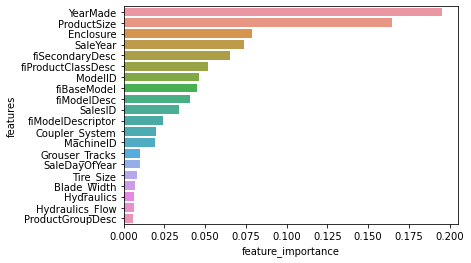

In [230]:
plot_features(X_train.columns, ideal_model.feature_importances_)

So as we can see the year that the bulldozer is made affects the price of the bulldozer alot